# Group 3 NYC AirBnB Data Principle Component Analysis

## Step-1: Import Packages,  Data Exploration & Cleaning
Intent should be to maximize information content while minimizing the number of dimensions or variables in the datset. Most of the variables in the dataframe have non null values except 'last_review', 'reviews_per_month', and 'license'. These columns are believed to have either little information value, or are believed to have other variables that would explain their effects anyway. Thus the aforementioned columns were removed. In addition all observations with zero values in the 'price' column were removed. The data columns 'accommodates', 'bedrooms', and 'beds' from the "listings-2.csv" dataset were merged with the primary "listings.csv" data. It is assumed that the 'price' will be the primary variable of interest.

In [31]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import seaborn as sb
import plotly.express as px

In [32]:
df_listings = pd.read_csv('Grp3Project_InitialData/listings.csv')
df_listings2 = pd.read_csv('Grp3Project_InitialData/listings-2.csv')
df_listings2 = df_listings2[['id','accommodates', 'bedrooms', 'beds']]
df_merged=df_listings.merge(df_listings2, on='id',how = 'inner')
df = df_merged
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 39881 entries, 0 to 39880
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              39881 non-null  int64  
 1   name                            39868 non-null  object 
 2   host_id                         39881 non-null  int64  
 3   host_name                       39831 non-null  object 
 4   neighbourhood_group             39881 non-null  object 
 5   neighbourhood                   39881 non-null  object 
 6   latitude                        39881 non-null  float64
 7   longitude                       39881 non-null  float64
 8   room_type                       39881 non-null  object 
 9   price                           39881 non-null  int64  
 10  minimum_nights                  39881 non-null  int64  
 11  number_of_reviews               39881 non-null  int64  
 12  last_review                     

/var/folders/g3/0mtl_c7d4c35y6985mzb9wjh0000gn/T/ipykernel_23919/3504942531.py:2: DtypeWarning: Columns (68) have mixed types. Specify dtype option on import or set low_memory=False.
  df_listings2 = pd.read_csv('Grp3Project_InitialData/listings-2.csv')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 39851 entries, 0 to 39880
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              39851 non-null  int64  
 1   neighbourhood_group             39851 non-null  object 
 2   latitude                        39851 non-null  float64
 3   longitude                       39851 non-null  float64
 4   room_type                       39851 non-null  object 
 5   price                           39851 non-null  int64  
 6   minimum_nights                  39851 non-null  int64  
 7   number_of_reviews               39851 non-null  int64  
 8   calculated_host_listings_count  39851 non-null  int64  
 9   availability_365                39851 non-null  int64  
 10  number_of_reviews_ltm           39851 non-null  int64  
 11  accommodates                    39851 non-null  int64  
 12  bedrooms                        

None

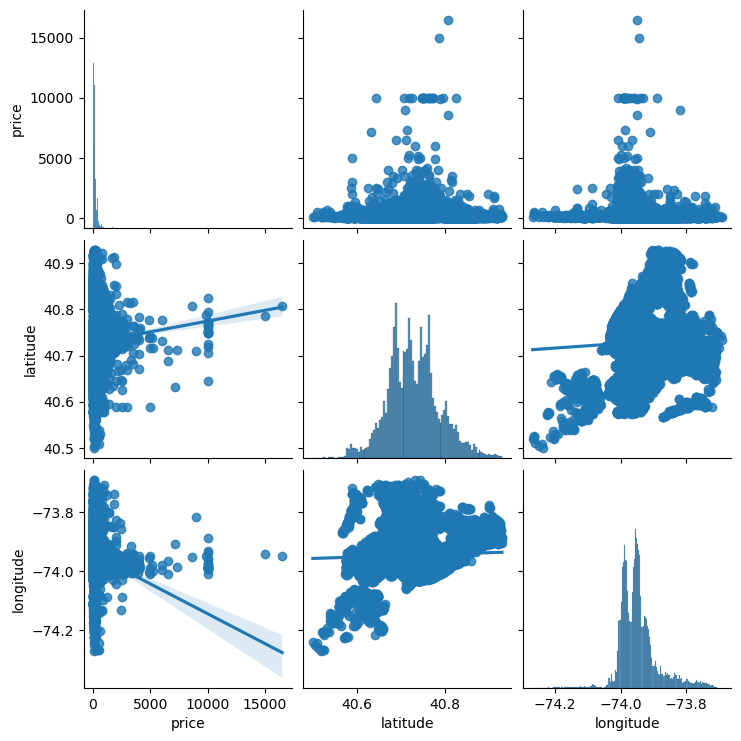

In [33]:
# remove deemed to be less than useful
df = df.drop(['license', 'reviews_per_month','last_review', 'name', 'host_id','neighbourhood', 'host_name'],axis = 1)
df = df.loc[(df['price']> 0)]# Remove all zero values from the price
display(df.info())
sb.pairplot(df[['price','latitude','longitude']], kind="reg")
plt.show()

The pairplot was developed to gain an understanding of the relationship between 'latitiude', 'longitude', and 'price'. Based on this visualization, that correlation appears to be weak.

## Step 2: Determine & Remove the Outliers
Process was to remove all outliers larger than q3 + (1.5 * IQR), or less than or equal to the minimum. In addition the latitude and longitude columns were removed from the dataset and replaced with the transformation 'lat_lon', which is the ratio latitude to longitude. The result reduced the number of observations in the data from 39881 to 32379.

In [34]:
df_stats = df.groupby('room_type')['price'].describe()
df_stats.reindex()
display(df_stats)

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,22761.0,251.546022,338.044654,10.0,128.00,180.0,275.0,15000.0
Hotel room,172.0,436.470930,282.491141,100.0,258.75,308.0,501.5,1998.0
Private room,16361.0,122.936495,356.373737,10.0,55.00,75.0,110.0,16500.0
Shared room,557.0,119.398564,454.106078,10.0,42.00,66.0,92.0,10000.0


In [35]:
# Create Table with outliers
df_stats['IQR'] = df_stats["75%"]- df_stats["25%"]
df_stats['upper_outlier'] = df_stats["75%"] + (1.5 * df_stats['IQR'])
df_stats['lower_outlier'] = df_stats["25%"] - (1.5 * df_stats['IQR'])
display(df_stats)

,count,mean,std,min,25%,50%,75%,max,IQR,upper_outlier,lower_outlier
room_type,,,,,,,,,,,
Entire home/apt,22761.0,251.546022,338.044654,10.0,128.00,180.0,275.0,15000.0,147.00,495.500,-92.500
Hotel room,172.0,436.470930,282.491141,100.0,258.75,308.0,501.5,1998.0,242.75,865.625,-105.375
Private room,16361.0,122.936495,356.373737,10.0,55.00,75.0,110.0,16500.0,55.00,192.500,-27.500
Shared room,557.0,119.398564,454.106078,10.0,42.00,66.0,92.0,10000.0,50.00,167.000,-33.000


,count,mean,std,min,25%,50%,75%,max
neighbourhood_group,,,,,,,,
Bronx,1402.0,108.601284,69.486647,10.0,60.00,88.5,136.0,450.0
Brooklyn,13128.0,134.428245,89.762035,10.0,68.00,110.0,175.0,529.0
Manhattan,11911.0,181.328100,109.420421,10.0,98.00,150.0,243.0,826.0
Queens,5546.0,114.920844,80.627031,10.0,60.00,90.0,147.0,495.0
Staten Island,392.0,115.339286,62.986011,33.0,69.75,100.0,146.5,412.0


,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,17723.0,201.686058,96.928796,10.0,129.0,179.0,250.00,496.0
Hotel room,147.0,372.020408,162.735034,100.0,259.0,307.0,478.00,826.0
Private room,14029.0,78.314705,34.130818,10.0,52.0,71.0,97.00,192.0
Shared room,480.0,65.729167,32.151935,10.0,40.0,60.0,84.25,165.0


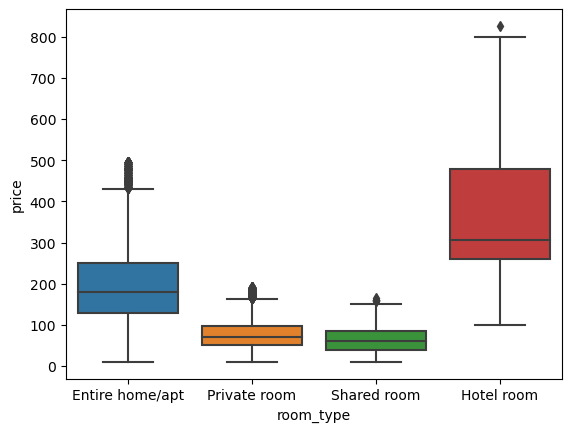

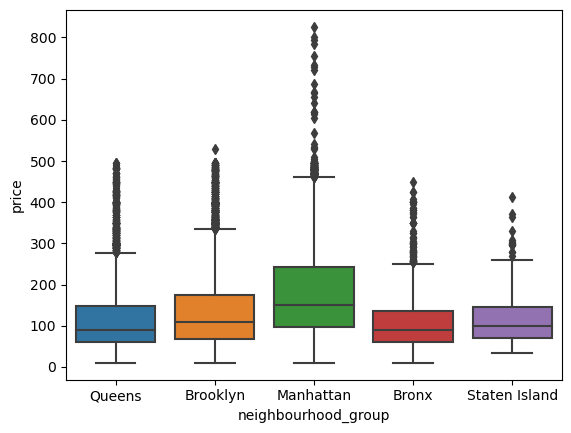

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32379 entries, 2 to 19816
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32379 non-null  int64  
 1   neighbourhood_group             32379 non-null  object 
 2   latitude                        32379 non-null  float64
 3   longitude                       32379 non-null  float64
 4   room_type                       32379 non-null  object 
 5   price                           32379 non-null  int64  
 6   minimum_nights                  32379 non-null  int64  
 7   number_of_reviews               32379 non-null  int64  
 8   calculated_host_listings_count  32379 non-null  int64  
 9   availability_365                32379 non-null  int64  
 10  number_of_reviews_ltm           32379 non-null  int64  
 11  accommodates                    32379 non-null  int64  
 12  bedrooms                        

None

,id,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,number_of_reviews_ltm,accommodates,bedrooms,beds
id,1.000000,-0.005113,0.089599,0.096412,-0.115629,-0.197180,0.048915,0.300940,-0.092104,0.061308,0.063806,0.032226
latitude,-0.005113,1.000000,0.064869,0.019817,0.030217,-0.024954,0.026630,-0.023385,-0.041022,-0.056381,-0.081690,-0.068552
longitude,0.089599,0.064869,1.000000,-0.213820,-0.094508,0.033915,-0.050985,0.149054,0.085231,0.034048,0.050830,0.048610
price,0.096412,0.019817,-0.213820,1.000000,-0.085153,-0.002248,0.138000,0.158387,0.079055,0.522097,0.422809,0.397797
minimum_nights,-0.115629,0.030217,-0.094508,-0.085153,1.000000,-0.143420,0.131208,-0.061766,-0.246215,-0.077999,-0.030931,-0.055318
number_of_reviews,-0.197180,-0.024954,0.033915,-0.002248,-0.143420,1.000000,-0.097199,0.087777,0.617163,0.079875,0.009797,0.083606
calculated_host_listings_count,0.048915,0.026630,-0.050985,0.138000,0.131208,-0.097199,1.000000,0.118627,-0.064573,-0.092212,-0.063453,-0.090776
availability_365,0.300940,-0.023385,0.149054,0.158387,-0.061766,0.087777,0.118627,1.000000,0.172682,0.134116,0.101947,0.127355
number_of_reviews_ltm,-0.092104,-0.041022,0.085231,0.079055,-0.246215,0.617163,-0.064573,0.172682,1.000000,0.126751,0.055105,0.113085
accommodates,0.061308,-0.056381,0.034048,0.522097,-0.077999,0.079875,-0.092212,0.134116,0.126751,1.000000,0.719106,0.769320


In [36]:
df1 = df[(df['room_type'] == "Entire home/apt") & (df['price']>=10) & (df['price']<= 496)]
df2 = df[(df['room_type'] == "Private room") & (df['price']>= 10) & (df['price']<= 192)]
df3 = df[(df['room_type'] == "Shared room") & (df['price']>= 10) & (df['price']<= 167)] 
df4 = df[(df['room_type'] == "Hotel room") & (df['price']>= 100) & (df['price']<= 865)]
frames = [df1, df2, df3, df4]
df_frames = pd.concat(frames)
df = df_frames.dropna()
display(df.groupby('neighbourhood_group')['price'].describe())
display(df.groupby('room_type')['price'].describe())
sb.boxplot(y = df['price'], x = df['room_type'])
plt.show()
sb.boxplot(y = df['price'], x = df['neighbourhood_group'])
plt.show()
display(df.info())
display(df.corr())

In [37]:
df_select = df[['price','accommodates', 'beds', 'bedrooms','neighbourhood_group','room_type', 'minimum_nights', 'number_of_reviews','calculated_host_listings_count','availability_365','number_of_reviews_ltm']]
df_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32379 entries, 2 to 19816
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price                           32379 non-null  int64  
 1   accommodates                    32379 non-null  int64  
 2   beds                            32379 non-null  float64
 3   bedrooms                        32379 non-null  float64
 4   neighbourhood_group             32379 non-null  object 
 5   room_type                       32379 non-null  object 
 6   minimum_nights                  32379 non-null  int64  
 7   number_of_reviews               32379 non-null  int64  
 8   calculated_host_listings_count  32379 non-null  int64  
 9   availability_365                32379 non-null  int64  
 10  number_of_reviews_ltm           32379 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 3.0+ MB


# Step 3:  Incorporate Categorical Variables into the Data and Scale the Dataset
The purpose of this step was to incorporate room type and neighborhood or NYC burrough into the dataset as "dummy variables" using one hot encoding. Also conducted during this step was a targeted correlation between price and the remaining variables.The strongest positive correlations were room types of 'Entire home/apt', neighborhood groups of 'Manhattan' and 365 day availability. Strongest negative correlation was a room type of "Private room". Finally the dataset was normalized.

In [38]:
 # One-hot encode the neighbourhood_group column
df_a = pd.concat([df_select,
               pd.get_dummies(df_select['neighbourhood_group'])],axis=1)


In [39]:
 # One-hot encode the room_type column
X = pd.concat([df_a,
               pd.get_dummies(df_select['room_type'])],axis=1)

In [16]:
# Drop the original categorical column and the response variable
df = X.drop(['neighbourhood_group','room_type'], axis=1)
display(df.info())
display(df[df.columns[0:]].corr()['price'][:].sort_values(ascending=False).to_frame())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32379 entries, 2 to 19816
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price                           32379 non-null  int64  
 1   accommodates                    32379 non-null  int64  
 2   beds                            32379 non-null  float64
 3   bedrooms                        32379 non-null  float64
 4   minimum_nights                  32379 non-null  int64  
 5   number_of_reviews               32379 non-null  int64  
 6   calculated_host_listings_count  32379 non-null  int64  
 7   availability_365                32379 non-null  int64  
 8   number_of_reviews_ltm           32379 non-null  int64  
 9   Bronx                           32379 non-null  uint8  
 10  Brooklyn                        32379 non-null  uint8  
 11  Manhattan                       32379 non-null  uint8  
 12  Queens                          

None

,price
price,1.000000
Entire home/apt,0.607875
accommodates,0.522097
bedrooms,0.422809
beds,0.397797
Manhattan,0.264734
availability_365,0.158387
Hotel room,0.153587
calculated_host_listings_count,0.138000
number_of_reviews_ltm,0.079055


In [17]:
X = scale(df)# Normalize the data
display(pd.DataFrame(X).describe().transpose())# Display the normalize data statistics
corr_ = pd.DataFrame(X).corr() #Display the correlation matrix for the normalized data
pd.DataFrame(corr_).style.background_gradient(cmap = 'YlOrRd')

,count,mean,std,min,25%,50%,75%,max
0,32379.0,5.108007e-16,1.000015,-1.384487,-0.727566,-0.272776,0.444783,6.862388
1,32379.0,5.061863e-14,1.000015,-1.037749,-0.471594,-0.471594,0.660715,7.454570
2,32379.0,-8.664168e-14,1.000015,-0.586236,-0.586236,-0.586236,0.388386,21.830072
3,32379.0,1.742541e-14,1.000015,-0.489507,-0.489507,-0.489507,-0.489507,18.068097
4,32379.0,-7.568670e-15,1.000015,-0.569068,-0.538195,0.017514,0.326241,37.990941
5,32379.0,-2.061979e-15,1.000015,-0.498317,-0.480370,-0.390637,-0.013758,17.627779
6,32379.0,-9.048595e-15,1.000015,-0.253004,-0.253004,-0.253004,-0.217735,7.717764
7,32379.0,1.033406e-14,1.000015,-0.937184,-0.937184,-0.428522,1.039332,1.715125
8,32379.0,-1.143874e-14,1.000015,-0.510749,-0.510749,-0.445015,0.015123,20.326924
9,32379.0,1.036295e-14,1.000015,-0.212743,-0.212743,-0.212743,-0.212743,4.700517


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1.000000,0.522097,0.397797,0.422809,-0.085153,-0.002248,0.138000,0.158387,0.079055,-0.082539,-0.104841,0.264734,-0.147348,-0.035411,0.607875,0.153587,-0.606871,-0.100743
1,0.522097,1.000000,0.769320,0.719106,-0.077999,0.079875,-0.092212,0.134116,0.126751,0.015564,0.006826,-0.032474,0.012452,0.040686,0.540947,-0.011040,-0.520288,-0.088523
2,0.397797,0.769320,1.000000,0.745591,-0.055318,0.083606,-0.090776,0.127355,0.113085,0.016075,0.011066,-0.064884,0.042509,0.060060,0.400668,-0.015412,-0.397842,-0.010391
3,0.422809,0.719106,0.745591,1.000000,-0.030931,0.009797,-0.063453,0.101947,0.055105,0.006153,0.046943,-0.074503,0.019080,0.040580,0.379796,-0.032347,-0.362468,-0.060047
4,-0.085153,-0.077999,-0.055318,-0.030931,1.000000,-0.143420,0.131208,-0.061766,-0.246215,-0.060267,-0.009962,0.091479,-0.061656,-0.034078,-0.018914,-0.030389,0.022159,0.003947
5,-0.002248,0.079875,0.083606,0.009797,-0.143420,1.000000,-0.097199,0.087777,0.617163,0.004540,0.017353,-0.044534,0.026912,0.017295,0.024102,0.049438,-0.028357,-0.010498
6,0.138000,-0.092212,-0.090776,-0.063453,0.131208,-0.097199,1.000000,0.118627,-0.064573,-0.046455,-0.090110,0.094373,0.028928,-0.024786,0.000450,0.002211,0.004841,-0.022937
7,0.158387,0.134116,0.127355,0.101947,-0.061766,0.087777,0.118627,1.000000,0.172682,0.107527,-0.077823,-0.067708,0.109646,0.070090,0.060712,0.048270,-0.070437,0.011911
8,0.079055,0.126751,0.113085,0.055105,-0.246215,0.617163,-0.064573,0.172682,1.000000,0.030428,-0.000181,-0.080481,0.077513,0.032025,0.058774,0.027536,-0.058056,-0.019345
9,-0.082539,0.015564,0.016075,0.006153,-0.060267,0.004540,-0.046455,0.107527,0.030428,1.000000,-0.175682,-0.162290,-0.096719,-0.023551,-0.036400,-0.014367,0.034465,0.016595


# Step 4: Principal Component Analysis
The PCA was conducted on the normalized data and indicate the following results:
- The variables 'price','accommodates','bedrooms', and 'beds' all have a significant amount of variance.
- The room type variables with the greatest variability are 'Entire home/apt'and'Private room' which have strong positive and strong negative correlations with the price respectively.
- The neighborhood group variable with the most significant variability is 'Manhattan'. Variance surrounding the other NYC boroughs is relatively small in comarison to Manhattan.
- Information content in the data is dispersed. There is significant variance clustered around 'price','accommodates','bedrooms', and 'beds'. As indicated by the scree plot and the measures of the cumulative variability, you dont get above 90% of the variability explained until you get to 12 of the 17 principal components. Once you get to roughly 16 principal components, marginal variability apears to go to zero. As evidenced by the correlation matrices and the heatmaps, most of the variables could be considered to have a significant component loading depending on the dimension in which they are viewed. That said, based on this analysis it seems the variables with the greatest information content are 'price', 'accommodates', 'bedrooms', 'beds', 'Manhattan', and 'Private Room'. Dimensionality efficiencies could be gained by doing the following: 1)combining the other boroughs into an 'other NYC borough' category; 2) Combining 'Hotel room' and 'Shared room' into an 'other_room_type' category.

In [19]:
# Select the number of components
pca1 = PCA(n_components=17)
# Fit the PCA model
pca1.fit(X)

PCA(n_components=17)

In [20]:
#The amount of variance that each PC explains
var = pca1.explained_variance_ratio_
display(var)

array([2.14963201e-01, 1.09789549e-01, 9.33599115e-02, 7.83676048e-02,
       6.34738335e-02, 6.11369170e-02, 5.85427739e-02, 5.66393710e-02,
       5.61483876e-02, 5.37502891e-02, 4.70746999e-02, 4.08547477e-02,
       2.11736225e-02, 1.86968508e-02, 1.46210449e-02, 1.14071957e-02,
       7.41336989e-33])

In [21]:
#Cumulative Variance explains
var1 = np.cumsum(np.round(pca1.explained_variance_ratio_, decimals=4)*100)
display(var1)

array([ 21.5 ,  32.48,  41.82,  49.66,  56.01,  62.12,  67.97,  73.63,
        79.24,  84.62,  89.33,  93.42,  95.54,  97.41,  98.87, 100.01,
       100.01])

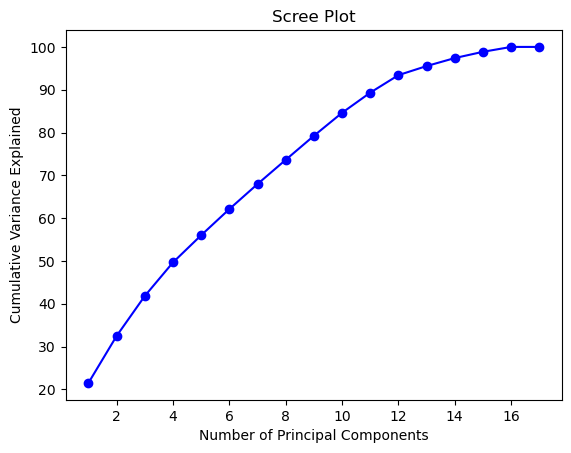

In [22]:
var1 = pd.DataFrame(var1, index=np.arange(1,18))
plt.plot(var1,'-o',color='blue')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.savefig('scree_plot.png',dpi=100,bbox_inches='tight')
plt.show()

In [27]:
# Select the number of components
pca12 = PCA(n_components=12)
pca12.fit(X)
data_pca12 = pca12.transform(X)

# Convert the numpy array to pandas DataFrame
data_pca12 = pd.DataFrame(data_pca12)
data_pca12.columns = ["PC"+str(i) for i in range(1,13)]

# Show the head of the DataFrame
display(data_pca12.head())
display(data_pca12.corr())


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,10.408834,-2.344001,-1.814731,-5.718018,0.671663,-1.350063,-1.763709,1.774149,0.885797,2.998342,-1.176287,-0.015795
1,1.994100,-0.075959,-1.538568,0.421726,-0.569717,0.403489,0.094000,0.214057,0.082609,-0.331779,-0.114395,0.410393
2,3.443012,-0.979823,-2.398937,-0.372878,0.500755,-0.580506,-0.500857,0.419433,0.290769,1.196614,0.013746,-0.660340
3,0.663807,-0.231886,2.900867,1.744677,-0.329584,-0.001760,0.398493,-0.924713,-0.297534,0.969842,1.074605,1.261835
4,2.175902,-0.964989,-1.417536,0.497505,-0.131167,-0.143219,0.017889,0.008734,0.073529,0.593536,0.448348,-0.009065


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
PC1,1.000000e+00,-9.367874e-15,-4.250197e-17,-4.800787e-16,-3.183311e-16,3.786443e-16,4.232745e-16,-3.747458e-16,-7.036852e-16,1.038979e-16,-9.006476e-16,3.703925e-16
PC2,-9.367874e-15,1.000000e+00,-3.966588e-16,-1.127041e-17,2.394168e-16,-4.259401e-16,2.846328e-16,-2.842354e-16,-1.066748e-16,4.549203e-16,6.231718e-16,-8.833200e-17
PC3,-4.250197e-17,-3.966588e-16,1.000000e+00,-4.185388e-16,4.436378e-16,2.034873e-16,-2.382072e-16,-8.835385e-16,-2.702592e-17,-1.158671e-16,7.595044e-17,1.673480e-16
PC4,-4.800787e-16,-1.127041e-17,-4.185388e-16,1.000000e+00,-9.435867e-17,1.865661e-16,9.220008e-17,4.615917e-16,-1.815826e-16,-9.286500e-17,-1.412070e-16,-6.496090e-17
PC5,-3.183311e-16,2.394168e-16,4.436378e-16,-9.435867e-17,1.000000e+00,8.904643e-17,-2.446445e-16,-1.473113e-16,-7.479385e-17,6.435135e-16,6.905564e-16,6.608961e-16
PC6,3.786443e-16,-4.259401e-16,2.034873e-16,1.865661e-16,8.904643e-17,1.000000e+00,-6.550573e-16,-2.775147e-16,1.515875e-16,1.659912e-16,-4.741624e-16,4.304761e-17
PC7,4.232745e-16,2.846328e-16,-2.382072e-16,9.220008e-17,-2.446445e-16,-6.550573e-16,1.000000e+00,-1.087385e-15,-1.185479e-16,1.771325e-15,-1.318270e-15,-4.203726e-16
PC8,-3.747458e-16,-2.842354e-16,-8.835385e-16,4.615917e-16,-1.473113e-16,-2.775147e-16,-1.087385e-15,1.000000e+00,2.061112e-15,-6.285077e-16,-1.293844e-16,1.178207e-15
PC9,-7.036852e-16,-1.066748e-16,-2.702592e-17,-1.815826e-16,-7.479385e-17,1.515875e-16,-1.185479e-16,2.061112e-15,1.000000e+00,-7.139146e-16,2.231421e-16,2.764994e-17
PC10,1.038979e-16,4.549203e-16,-1.158671e-16,-9.286500e-17,6.435135e-16,1.659912e-16,1.771325e-15,-6.285077e-16,-7.139146e-16,1.000000e+00,9.914550e-16,2.395109e-17


All pairwise combinations are cose to zero which is indicative of no multicollinearity among principal components.


In [28]:
# Show the loadings for the 1st components
pca12.components_[[0]]

array([[ 0.38123082,  0.43435241,  0.39206466,  0.37877221, -0.052029  ,
         0.05694837, -0.01712033,  0.09697947,  0.09037581, -0.01045356,
        -0.02180736,  0.04854811, -0.03471025,  0.02286762,  0.41426637,
         0.01612292, -0.40842703, -0.04053656]])

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
price,0.381231,0.195381,0.107851,0.109316,-0.177495,0.059470,-0.059856,0.112114,0.000190,-0.087657,-0.126942,-0.014188
accommodates,0.434352,-0.106824,-0.091441,-0.136268,0.082277,-0.057178,-0.107115,0.054155,-0.001193,0.118656,-0.040384,-0.028951
beds,0.392065,-0.153689,-0.114297,-0.213203,0.132296,-0.071519,-0.115738,0.078000,0.086328,0.254296,-0.085453,-0.072723
bedrooms,0.378772,-0.118587,-0.174499,-0.220923,0.092520,-0.070022,-0.170345,0.089047,0.046906,0.245414,-0.126858,-0.080985
minimum_nights,-0.052029,0.268078,-0.190571,-0.104596,-0.162378,-0.040987,-0.001023,-0.143054,0.024932,0.552394,0.679383,0.147426
number_of_reviews,0.056948,-0.385530,0.385737,0.313238,-0.027252,-0.132639,0.016249,-0.099255,-0.041051,0.269829,0.199854,-0.091446
calculated_host_listings_count,-0.017120,0.219913,0.100886,-0.137547,-0.629212,0.196276,0.033153,-0.131329,-0.047730,0.197620,-0.230211,-0.579571
availability_365,0.096979,-0.141438,0.228854,-0.224226,-0.344330,0.465614,0.009668,-0.034064,0.098013,0.072943,-0.140735,0.690978
number_of_reviews_ltm,0.090376,-0.416692,0.414679,0.249347,-0.079801,-0.063938,0.033220,-0.102373,-0.063984,0.153124,0.036102,-0.077412
Bronx,-0.010454,-0.102222,0.069107,-0.161622,0.360841,0.682568,-0.017487,0.078415,-0.412633,0.001263,0.228987,-0.252399


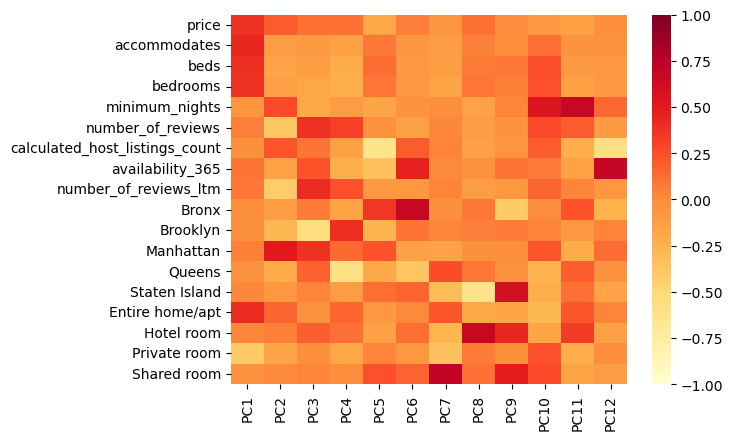

In [30]:
corr_12 = pd.DataFrame(pca16.components_.transpose(),
             index=df.loc[:,'price':'Shared room'].columns,
             columns=["PC"+str(i) for i in range(1,13)])
display(pd.DataFrame(corr_12).style.background_gradient(cmap = 'YlOrRd'))
ax = sb.heatmap(corr_12, annot=False, cmap = 'YlOrRd', vmin = -1, vmax = 1)
plt.show()